In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# to install all dependencies use, uncomment the following line and restart the kernel
# %pip install -U -r requirements.txt

In [107]:
datetag = None

In [108]:
if datetag is None:
    from time import strftime, gmtime
    datetag = strftime("%Y-%m-%d", gmtime())
datetag

'2022-11-23'

In [109]:
datetag = '2022-11-23'

# Un/Supervised learning of Temporally Heterogeneous Connections in spiking neurons


We design a model based on heterosynaptic delays. We will define in the assembly of neurons where each synapse
is defined by a weight *ws* at different delays *τs*. See the following figure: 

**Abstract:** The response of a biological neuron depends on the precise timing of afferent spikes. This temporal aspect of the neuronal code is essential in understanding information processing in neurobiology and applies particularly well to the output of neuromorphic hardware such as event-based cameras. Though, most artificial neuronal models do not take advantage of this minute temporal dimension and here, we develop a model for the efficient detection of temporal spiking motifs based on a layer of neurons with heterogeneous delays. Indeed, the variety of synaptic delays on the dendritic tree allows to synchronize synaptic inputs as they reach the basal dendritic tree. We show this can be formalized as time-invariant logistic regression which can trained using labelled data. We apply this model for solving the specific problem of detecting motion and demonstrate its use by applying it on synthetic naturalistic videos transformed to event-based streams similar to the output of a silicon retina. In particular, we show how its accuracy may evolve as a function of the total computational load. This end-to-end event-based computational brick could help improve the performance of future Spiking Neural Network solutions currently used in neuromorphic chips.

In [110]:
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [111]:
import numpy as np
phi = np.sqrt(5)/2 + 1/2
import matplotlib
import matplotlib.pyplot as plt

import matplotlib
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

figpath = None
figpath = '../../2022-11-23_THC-CoSyNe_637e00e2c76207e2838c427d'

def printfig(fig, name, ext='pdf', figpath=figpath, dpi_exp=None, bbox='tight'):
    fig.savefig(os.path.join(figpath, name + '.' + ext), dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [112]:
if not(figpath is None):
    %mkdir -p {figpath}

In [113]:
# https://docs.python.org/3/library/dataclasses.html?highlight=dataclass#module-dataclasses
from dataclasses import dataclass, asdict, field

@dataclass
class Params:
    datetag: str = datetag
    N_pre: int = 144 # number of presynaptic inputs
    N_PG_time: int = 71 # number of timesteps in PG, must be a odd number for convolutions
    N_PGs: int = 35 # number of polychronous groups
    E_PG: float = 4. # excitability range of PGs
    p_PG: float = .005 # ratio of non-zero coefficients in PGs
    tau_decay: float = .4 # time constant for the decay of the PG enveloppe
    tau_rise: float = .05 # time constant for the rise of the PG enveloppe

    ## Raster plots
    N_time: int = 1000 # number of timesteps for the raster plot
    N_trials: int = 10 # number of trials
    p_B: float = .001 # prior probability of firing for postsynaptic raster plot
    p_A: float = .001 # prior probability of firing for presynaptic raster plot
    seed: int = 42 # seed

    ## figures
    verbose: bool = False # Displays more verbose output.
    fig_width: float = 12 # width of figure
    phi: float = 1.61803 # beauty is gold
    N_PG_show: float = 5 # number of PG to show in plot_PG


In [114]:
opt = Params()
opt

Params(datetag='2022-11-23', N_pre=144, N_PG_time=71, N_PGs=35, E_PG=4.0, p_PG=0.005, tau_decay=0.4, tau_rise=0.05, N_time=1000, N_trials=10, p_B=0.001, p_A=0.001, seed=42, verbose=False, fig_width=12, phi=1.61803, N_PG_show=5)

### generative & inference models for polychronous groups

In [115]:
class ABCD:

    def __init__(self, opt):
        self.opt: Params = opt
        self.init()

    def init(self):
        self.logit_p_A = torch.logit(torch.tensor(self.opt.p_A))

        temporal_mod = torch.zeros(self.opt.N_PG_time)
        time = torch.linspace(0, 1, self.opt.N_PG_time)
        temporal_mod = torch.exp(- time / self.opt.tau_decay)
        temporal_mod *= 1 - torch.exp(- time / self.opt.tau_rise)
        # temporal_mod = temporal_mod.flip([0])
        #self.temporal_mod = (torch.eye(self.opt.N_PGs).unsqueeze(2)) * (temporal_mod.unsqueeze(0).unsqueeze(0))
        self.temporal_mod = torch.ones((self.opt.N_pre, self.opt.N_PGs, 1)) * (temporal_mod.unsqueeze(0).unsqueeze(0))

        spike = torch.tensor([1, -.8, -.2])
        self.spike = (torch.eye(self.opt.N_PGs).unsqueeze(2)) * (spike.flip([0]).unsqueeze(0).unsqueeze(0))


    def set_PG(self, seed=None, seed_offset=0):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        
        # 1/ define PGs as matrices to be used as kernels
        PG = self.opt.E_PG * torch.randn(self.opt.N_pre, self.opt.N_PGs, self.opt.N_PG_time)
        #threshold = torch.abs(PG).quantile(1-self.opt.p_PG)

        # 2/ zero out everything below the threshold
        # TODO : get analytically
        from scipy.stats import norm
        threshold = self.opt.E_PG * norm.ppf(1-self.opt.p_PG)
        PG *= (PG > threshold)

        # 3/ modulate in time
        PG *= self.temporal_mod

        # 4/ convolve with a spike shape to induce some sort of refractory period
        PG = torch.conv1d(PG, self.spike, padding=self.spike.shape[-1]//2)
        return PG

    def get_b(self, seed=None, seed_offset=1):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        # draw causes (PGs) as a matrix of sparse PG activations uniformly in postsynaptic space and time
        # to avoid border effects with the temporal convolution,
        # we set it to zero everywhere
        b_proba = torch.zeros(self.opt.N_trials, self.opt.N_PGs, self.opt.N_time)
        # except outside the borders
        b_proba[:, :, (self.opt.N_PG_time//2):-(self.opt.N_PG_time//2)] = self.opt.p_B*self.opt.p_B
        return torch.bernoulli(b_proba)

    def plot_raster(self, raster, raster_post=None, PG=None, 
                    i_trial=0, xticks=6, yticks=16, spikelength=.9, 
                    colors=None, figsize=None, subplotpars=subplotpars, 
                    ylabel='address', linewidths=0.8):

        N_neurons = raster.shape[1]
        if colors is None: # blue if nothing assigned
            colors = ['b'] * N_neurons
        else: # give the colors or ...
            if len(colors)==1: # ... paint everything the same color
                colors = colors[0] * N_neurons
        if figsize is None: figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        fig, ax = plt.subplots(1, 1, figsize=figsize)
        if raster_post is None:
            for i in range(0, N_neurons):
                ax.eventplot(np.where(raster[i_trial, i, :] == 1.)[0], 
                    colors=colors[i], lineoffsets=1.*i+spikelength/2, 
                    linelengths=spikelength, linewidths=linewidths)
        else:
            for i_PG in range(self.opt.N_PGs):
                b_ = torch.zeros_like(raster_post)
                b_[i_trial, i_PG, :] = raster_post[i_trial, i_PG, :]
                a_ = self.draw_a(b_, PG)
                for i in range(0, self.opt.N_pre):
                    ax.eventplot(np.where(a_[i_trial, i, :] == 1.)[0], colors=colors[i_PG], lineoffsets=1.*i+spikelength/2, 
                    linelengths=spikelength, linewidths=linewidths)
    
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time (a. u.)')
        ax.set_xlim(0, self.opt.N_time)
        ax.set_ylim(0, N_neurons)

        # ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(yticks))
        ax.set_yticks(np.linspace(0, N_neurons, yticks, endpoint=False)+.5)
        ax.set_yticklabels(np.linspace(1, N_neurons, yticks, endpoint=True).astype(int))
        for side in ['top', 'right']: ax.spines[side].set_visible(False)
        
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(4))
        ax.set_xticks(np.linspace(1, self.opt.N_time, xticks, endpoint=True))
        ax.set_xticklabels(np.linspace(1, self.opt.N_time, xticks, endpoint=True).astype(int))

        ax.grid(visible=True, axis='y', linestyle='-', lw=.5)
        ax.grid(visible=True, axis='x', which='both', linestyle='-', lw=.1)

        return fig, ax

    def plot_b(self, b, i_trial=0, xticks=6, yticks=16, spikelength=.9, colors=None, figsize=None, subplotpars=subplotpars):
        fig, ax = self.plot_raster(raster=b, i_trial=i_trial, xticks=xticks, yticks=yticks, spikelength=spikelength, colors=colors, figsize=figsize, subplotpars=subplotpars, ylabel='@ PG')
        return fig, ax

    def model_a_logit(self, b, PG):
        """
        defines the evidence of firing for each presynaptic address over time
        input b -> postsynaptic raster plot
            PG -> polychronous groups as spatio temporal kernels
            p_A -> prior proba of firing for the presynaptic addresses
        
        """
        logit_B = torch.conv1d(b*1., PG, padding=self.opt.N_PG_time//2)
        return self.logit_p_A + logit_B

    def model_a(self, b, PG):
        """
        defines the probability of firing for each presynaptic address over time from its evidence
        
        """
        logit_A = self.model_a_logit(b, PG)
        return torch.sigmoid(logit_A)

    def draw_a(self, b, PG, seed=None, seed_offset=2):
        # draws binary events from the probability of firing
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        # generate the corresponding raster plot
        A_proba = self.model_a(b, PG)
        return torch.bernoulli(A_proba)

    def plot_a(self, a, b=None, PG=None, i_trial=0, xticks=6, yticks=16, spikelength=.9, colors=None, figsize=None, subplotpars=subplotpars):
        fig, ax = self.plot_raster(raster=a, raster_post=b, PG=PG, i_trial=i_trial, xticks=xticks, yticks=yticks, spikelength=spikelength, colors=colors, figsize=figsize, subplotpars=subplotpars, ylabel='@ Synapse')
        return fig, ax

    def inference_with_PGs(self, a, b, PG, max_quant=10000000):
        # infer 
        b_hat = torch.conv_transpose1d(a*1., PG, padding=self.opt.N_PG_time//2)
        # decision
        p_B = b.sum()/(self.opt.N_trials*self.opt.N_PGs*self.opt.N_time) # ça suppose qu'on connait b.sum()...
        if len(b_hat.ravel()) > max_quant:
            ind_quant = torch.randperm(len(b_hat.ravel()))[:max_quant]
            b_threshold = torch.quantile(b_hat.ravel()[ind_quant], 1-env.opt.p_B)
        else:
            b_threshold = torch.quantile(b_hat, 1-p_B)
        b_hat_bin = (b_hat > b_threshold) * 1.
        # b_hat_bin = torch.bernoulli(b_hat)
        return b_hat, b_hat_bin

    def generative_model(self, seed=None, seed_offset=3):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        PG, b = self.set_PG(seed=seed), self.get_b(seed=seed+1)
        a = self.draw_a(b, PG, seed=seed+2)
        return a, b, PG

    def test_model(self, PG, PG_true=None, seed=None, seed_offset=4):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        if PG_true is None: PG_true = PG
        # define PGs
        # draw causes (PGs)
        b = self.get_b(seed=seed)
        # generate the corresponding raster plot
        a = self.draw_a(b, PG_true, seed=seed+1)
        # infer 
        b_hat, b_hat_bin = self.inference_with_PGs(a, b, PG)
        # count
        accuracy = torch.mean((b_hat_bin == b)*1.)
        TP = torch.mean(b_hat_bin[b==1]*1.)
        TN = 1-torch.mean(b_hat_bin[b==0]*1.)
        return accuracy, TP, TN
        
    def plot_PG(self, PG, cmap='seismic', colors=None, aspect=None, figsize=None, subplotpars=subplotpars, N_PG_show=None):
        if N_PG_show == None: N_PG_show = self.opt.N_PG_show
        if PG.dtype == torch.bool:
            PG_max = 1
            PG_min = 0
            cmap = 'binary'
        else:
            # PG = PG.numpy()
            PG_max = np.abs(PG).max()#.item()
            PG_min = -PG_max

        if figsize is None:
            figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        fig, axs = plt.subplots(1, N_PG_show, figsize=figsize, subplotpars=subplotpars)
        for i_PG in range(N_PG_show):
            ax = axs[i_PG]
            ax.set_axisbelow(True)

            ax.pcolormesh(PG[:, i_PG, :], cmap=cmap, vmin=PG_min, vmax=PG_max)
            #ax.imshow(PG[:, i_PG, :], cmap=cmap, vmin=PG_min, vmax=PG_max, interpolation='none')
            
            ax.set_xlim(0, PG.shape[2])

            ax.set_xlabel('Delay')
            ax.set_title(f'PG #{i_PG+1}', color='k' if colors is None else colors[i_PG])
            if not aspect is None: ax.set_aspect(aspect)

            ax.set_ylim(0, self.opt.N_pre)
            ax.set_yticks(np.arange(0, self.opt.N_pre, 1)+.5)
            if i_PG>0: 
                ax.set_yticklabels([])
            else:
                ax.set_yticklabels(np.arange(0, self.opt.N_pre, 1)+1)

            for side in ['top', 'right']: ax.spines[side].set_visible(False)
            ax.set_xticks([0, self.opt.N_PG_time//2, self.opt.N_PG_time-1])
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(self.opt.N_PG_time//4))
            #ax.xaxis.set_minor_locator(AutoMinorLocator(4))
            #ax.set_xticklabels([-(self.opt.N_PG_time//2), 0, self.opt.N_PG_time//2])
            ax.set_xticklabels([0, (self.opt.N_PG_time//2), (self.opt.N_PG_time)])
            # ax.grid(True, axis='y', linestyle='-', lw=1)
            # ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)

        axs[0].set_ylabel('@ Synapse')
        return fig, axs

    def plot_a_histo(self, a,  xticks=1, spikelength=.9, colors=None, figsize=None, subplotpars=subplotpars):
        fig, ax = plt.subplots(1, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax.step(np.arange(self.opt.N_pre), a.numpy().mean(axis=(0, 2)), label='firing rate')
        ax.hlines(self.opt.p_A, 0, self.opt.N_pre, linestyles='--', color='orange', label='probability of firing for each address')
        ax.set_xlabel('address')
        ax.set_ylim(0)
        ax.legend()
        return fig, ax

    def plot_inference(self, b, b_hat, b_hat_bin, i_trial = 0, t_min = 100, t_max = 150, subplotpars=subplotpars):
        fig, ax = plt.subplots(1, 3, figsize=(self.opt.fig_width, self.opt.fig_width), subplotpars=subplotpars)
        ax[2].imshow(b_hat_bin[i_trial, :, t_min:t_max])
        ax[0].imshow(b[i_trial, :, t_min:t_max])
        ax[1].imshow(b_hat[i_trial, :, t_min:t_max])
        return fig, ax

    def plot_inference_histo(self, b_hat, nb_bins = 100):
        fig, ax = plt.subplots(1, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax.hist(b_hat.numpy().ravel(), bins=nb_bins)
        ax.set_ylabel('smarts')
        ax.set_xlabel('value of b_hat')
        ax.set_yscale('log')
        return fig, ax


In [116]:
env = ABCD(opt)

In [117]:
env.opt

Params(datetag='2022-11-23', N_pre=144, N_PG_time=71, N_PGs=35, E_PG=4.0, p_PG=0.005, tau_decay=0.4, tau_rise=0.05, N_time=1000, N_trials=10, p_B=0.001, p_A=0.001, seed=42, verbose=False, fig_width=12, phi=1.61803, N_PG_show=5)

#### dev sandox

In [118]:
len(env.spike)//2, env.spike.shape

(17, torch.Size([35, 35, 3]))

In [119]:
env = ABCD(opt)
a, b, PG = env.generative_model()

In [120]:
a.min(), a.max()

(tensor(0.), tensor(1.))

In [121]:
env.temporal_mod.shape

torch.Size([144, 35, 71])

In [122]:
PG.shape

torch.Size([144, 35, 71])

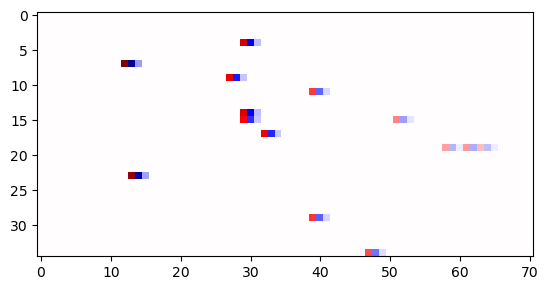

In [123]:
vmax = PG[0, :, :].abs().max()
plt.imshow(PG[0, :, :], cmap='seismic', vmin=-vmax, vmax=vmax)

# generative model for polychronous groups

In [124]:
opt = Params()
env = ABCD(opt)
a, b, PG = env.generative_model()
# env.plot_PG(PG);
# TODO find a better rule to generate PGs

Draw one instance of single PGs:

Draw the occurrences of PGs:

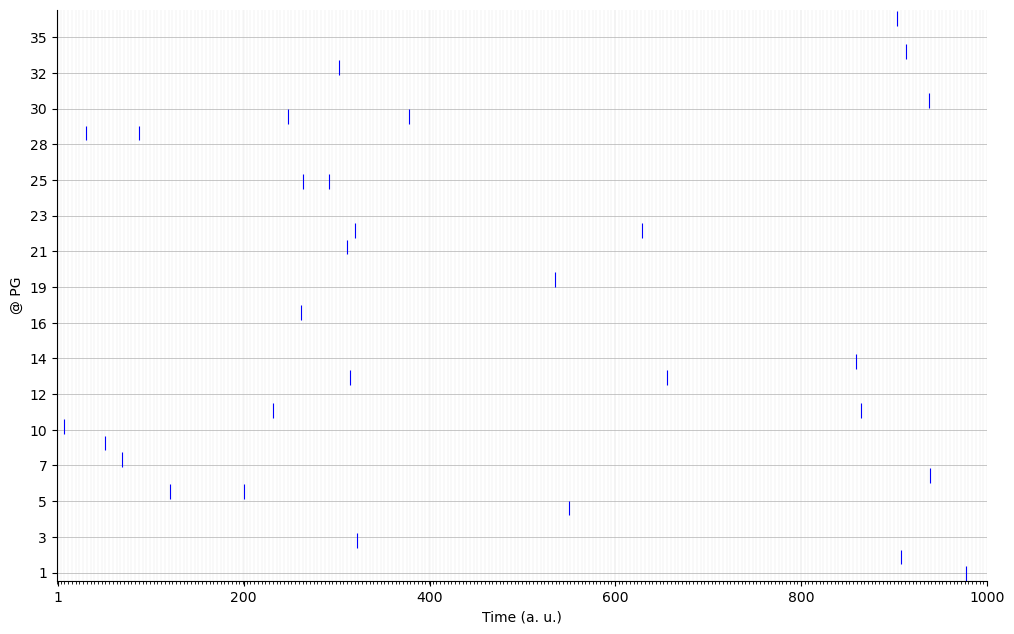

In [125]:
env.plot_b(b);

Resulting raster plot:

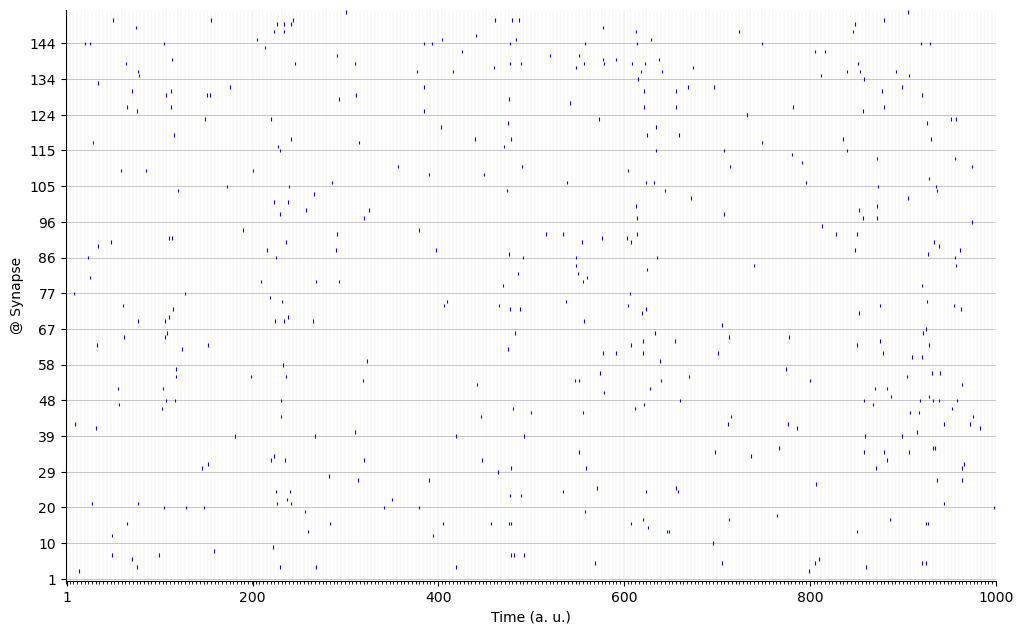

In [126]:
env.plot_a(a, i_trial=7);
# TODO correct this firing rate

In [127]:
a.mean(), b.mean(), b.mean(axis=(0, -1))

(tensor(0.003),
 tensor(0.001),
 tensor([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
         0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]))

# inference model for polychronous groups

knowing the raster plot `a`, let's try to infer `b` :

(<Figure size 1200x741.643 with 1 Axes>,
 <AxesSubplot: xlabel='value of b_hat', ylabel='smarts'>)

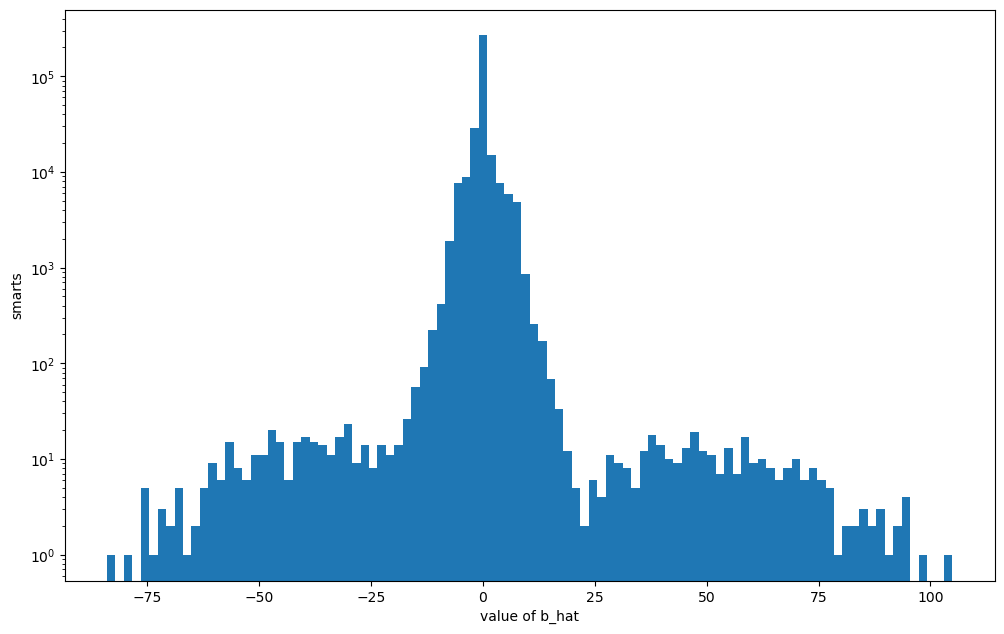

In [128]:
b_hat, b_hat_bin = env.inference_with_PGs(a, b, PG)
env.plot_inference_histo(b_hat)

(<Figure size 1200x1200 with 3 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object))

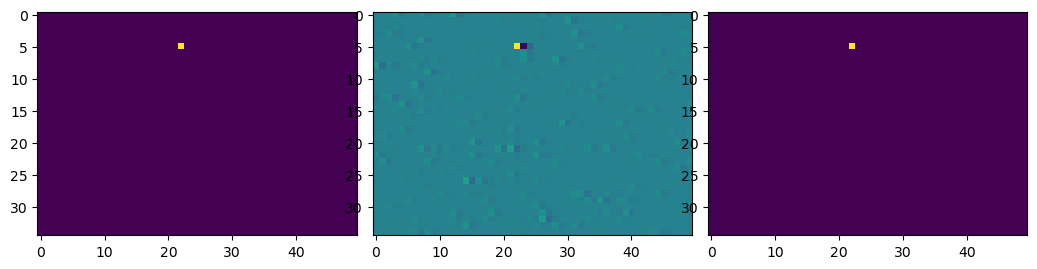

In [129]:
env.plot_inference(b, b_hat, b_hat_bin)

## test model, learning 

In [130]:
%%timeit
accuracy, TP, TN = env.test_model(PG, PG)

120 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [131]:
accuracy, TP, TN = env.test_model(PG, PG)
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.99%, TP=95.96%, TN=100.00%


## Figure 1

In [132]:
N_PGs = 4
opt_fig1 = Params(  datetag = datetag + '_fig1',
                    N_pre = 10, 
                    N_PGs = N_PGs,
                    N_PG_time = 71,
                    p_PG = .07,
                    p_A = 0.01,
                    p_B = 0.001,
                    N_PG_show = N_PGs,
                    N_trials = 1,
                    N_time = 240,
                    seed = 2373,
                    fig_width = 4.5,
                    )
                    
env_fig1 = ABCD(opt_fig1)
# a, b, PG = env_fig1.generative_model()
PG = env_fig1.set_PG(seed=opt_fig1.seed)
b = env_fig1.get_b(seed=opt_fig1.seed+1)

In [133]:
opt_fig1, env_fig1.opt, env_fig1.opt.N_pre, env_fig1.opt.N_PGs


(Params(datetag='2022-11-23_fig1', N_pre=10, N_PG_time=71, N_PGs=4, E_PG=4.0, p_PG=0.07, tau_decay=0.4, tau_rise=0.05, N_time=240, N_trials=1, p_B=0.001, p_A=0.01, seed=2373, verbose=False, fig_width=4.5, phi=1.61803, N_PG_show=4),
 Params(datetag='2022-11-23_fig1', N_pre=10, N_PG_time=71, N_PGs=4, E_PG=4.0, p_PG=0.07, tau_decay=0.4, tau_rise=0.05, N_time=240, N_trials=1, p_B=0.001, p_A=0.01, seed=2373, verbose=False, fig_width=4.5, phi=1.61803, N_PG_show=4),
 10,
 4)

In [134]:
env_fig1.opt.N_pre, env_fig1.opt.N_PGs, env_fig1.opt.N_PG_time

(10, 4, 71)

In [135]:
subplotpars_fig1 = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0.08, hspace=0.05,)
figsize = (env_fig1.opt.fig_width, env_fig1.opt.fig_width/2.5)
colors = ['r', 'g' , 'b' , 'm']

In [136]:
#b[0, 3, 350] = True
#b[0, 2, 350] = True
#b[0, 1, 150] = True
b[0, 0, 50] = True
b[0, 3, 180] = True
#b[0, 3, 42] = True
b[0, 1, 201] = True
b[0, 1, 114] = True
b[0, 2, 42] = True
b[0, 2, 104] = True
#b[0, 0, 50] = True
b.shape

torch.Size([1, 4, 240])

In [137]:
PG.shape

torch.Size([10, 4, 71])

In [138]:
PG.mean(), PG.abs().max(), PG.min(), PG.max()

(tensor(    0.000), tensor(7.163), tensor(-5.730), tensor(7.163))

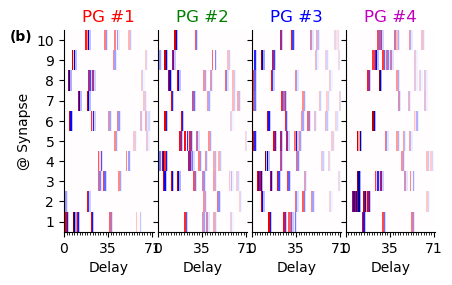

In [139]:
fig, axs = env_fig1.plot_PG(PG, colors=colors)
fig.text(0.03, 0.95,'(b)', horizontalalignment='center', verticalalignment='center', weight='bold')
if not figpath is  None: printfig(fig, 'figure_1b.pdf')
plt.show()

Then from the following raster plot, each PG described if the figure above will be selective to the spatio-temporal pattern of the same color: 

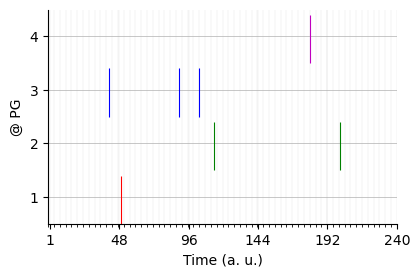

In [140]:
fig, ax = env_fig1.plot_b(b, colors=colors, yticks=env_fig1.opt.N_PGs)

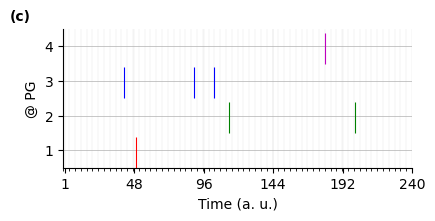

In [141]:
fig, ax = env_fig1.plot_b(b, colors=colors, figsize=figsize, subplotpars=subplotpars_fig1, yticks=env_fig1.opt.N_PGs)
fig.text(0.03, 0.95,'(c)', horizontalalignment='center', verticalalignment='center', weight='bold')

if not figpath is  None: printfig(fig, 'figure_1c')

It results in the following activation of the postsynaptic neurons (activation probability with a Bernoullin trial):

In [142]:
env_fig1.opt.N_pre, a.shape, b.shape

(10, torch.Size([10, 144, 1000]), torch.Size([1, 4, 240]))

In [143]:
a = env_fig1.draw_a(b, PG)

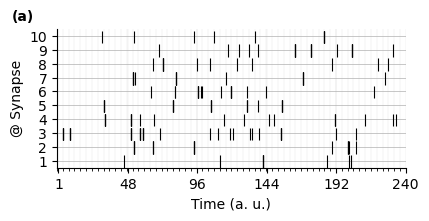

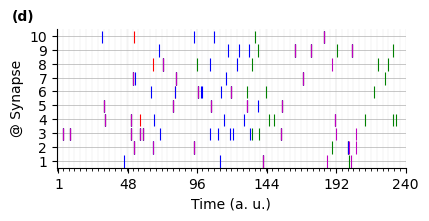

In [144]:
for suff in ['_k', '']:
    fig, ax = env_fig1.plot_a(a, b, PG, colors=colors if suff=='' else ['k'], figsize=figsize, subplotpars=subplotpars_fig1, yticks=env_fig1.opt.N_pre)
    
    if not figpath is None: 
        fig.text(0.05, 0.95, '(a)' if suff=='_k' else '(d)', horizontalalignment='center', verticalalignment='center', weight='bold')
        printfig(fig, 'figure_1a' + suff)
    else:
        fig.text(0.05, 0.95,'(before)' if suff=='_k' else '(after)', horizontalalignment='center', verticalalignment='center', weight='bold')

    plt.show()

TODO: montrer des PGs générant des vagues, du bruit de Poisson, des one-spike per neuron, ...

## scanning parameters

In [145]:
%mkdir -p data_cache

In [ ]:
opt_scan = Params()
opt_scan.datetag

'2022-11-23'

In [ ]:
opt_scan.N_time = 2**14
opt_scan.N_time

In [147]:
%ls data_cache/{opt.datetag}_scan_*.json

zsh:1: no matches found: data_cache/2022-11-23_scan_*.json


In [148]:
# %rm -f data_cache/{datetag}_scan_*.json

zsh:1: no matches found: data_cache/2022-11-23_scan_*.json


In [149]:
scan_dicts= {'N_PGs' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1364, 2351],
             'N_PG_time' : [1, 3, 7, 15, 31, 63, 127],
             'N_pre' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1364, 2351],
            }

label_dicts= {'N_PGs' : 'number of PGs',
             'N_PG_time' : 'duration of PGs',
             'N_pre' : 'number of presynaptic inputs',
            }
import os
import time
import pandas as pd
import numpy as np

N_cv = 10
seed = 1000 # np.random.randint(1000)
verb = False

for key in scan_dicts:
    filename = f'data_cache/{opt.datetag}_scan_{key}.json'
    print(f'{filename=}')
    if os.path.isfile(filename):
        df_scan = pd.read_json(filename)
    else:
        measure_columns = [key, 'accuracy', 'TP', 'TN', 'time']
        df_scan = pd.DataFrame([], columns=measure_columns)
        i_loc = 0
        for i_value, value in enumerate(scan_dicts[key]):
            if verb: print('i_value', i_value + 1, ' /', len(scan_dicts[key]), end='\t')

            for i_cv in  range(N_cv):
                # tic
                since = time.time()
                new_dict = asdict(opt)
                # print(key, value)
                new_dict[key] = value
                new_opt = Params(**new_dict)
                # print(new_opt)
                # make a new model
                new_env = ABCD(new_opt)
                # draw a new set of PGs
                PG = new_env.set_PG(seed=seed+i_loc)
                # test it
                accuracy, TP, TN = new_env.test_model(PG, PG, seed=seed+i_loc)
                # toc
                elapsed_time = time.time() - since
                df_scan.loc[i_loc] = {key:value, 'accuracy':accuracy.item(), 'TP':TP.item(), 'TN':TN.item(), 'time':elapsed_time}
                i_loc += 1
                if verb: print(f" - One pass completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

        df_scan.to_json(filename)
    print(df_scan)

filename='data_cache/2022-11-23_scan_N_PGs.json'
     N_PGs  accuracy        TP        TN       time
0        8  0.999950  0.976744  0.999975   0.057593
1        8  0.999950  0.974684  0.999975   0.039991
2        8  0.999975  0.984615  0.999987   0.051199
3        8  0.999950  0.977273  0.999975   0.034688
4        8  0.999925  0.961039  0.999962   0.041304
..     ...       ...       ...       ...        ...
125   2351  0.999321  0.665774  0.999655  12.552828
126   2351  0.999346  0.670316  0.999675  12.583756
127   2351  0.999340  0.667187  0.999675  12.560140
128   2351  0.999330  0.660350  0.999669  12.674306
129   2351  0.999334  0.665773  0.999668  12.591549

[130 rows x 5 columns]
filename='data_cache/2022-11-23_scan_N_PG_time.json'
    N_PG_time  accuracy        TP        TN      time
0           1  0.998917  0.000000  1.000000  0.093882
1           1  0.999011  0.000000  1.000000  0.081239
2           1  0.999077  0.000000  1.000000  0.027095
3           1  0.998951  0.000000 

     N_PGs  accuracy        TP        TN       time
0        8  0.999950  0.976744  0.999975   0.057593
1        8  0.999950  0.974684  0.999975   0.039991
2        8  0.999975  0.984615  0.999987   0.051199
3        8  0.999950  0.977273  0.999975   0.034688
4        8  0.999925  0.961039  0.999962   0.041304
..     ...       ...       ...       ...        ...
125   2351  0.999321  0.665774  0.999655  12.552828
126   2351  0.999346  0.670316  0.999675  12.583756
127   2351  0.999340  0.667187  0.999675  12.560140
128   2351  0.999330  0.660350  0.999669  12.674306
129   2351  0.999334  0.665773  0.999668  12.591549

[130 rows x 5 columns]


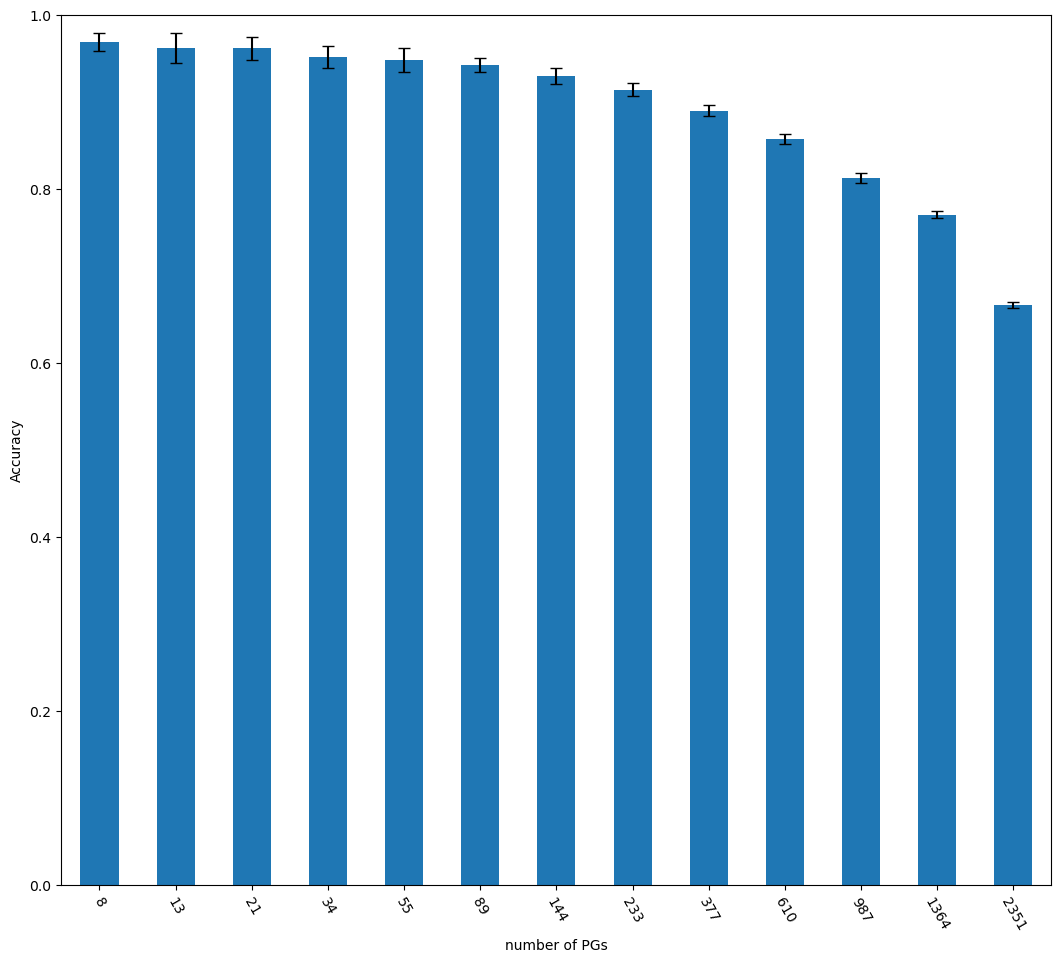

    N_PG_time  accuracy        TP        TN      time
0           1  0.998917  0.000000  1.000000  0.093882
1           1  0.999011  0.000000  1.000000  0.081239
2           1  0.999077  0.000000  1.000000  0.027095
3           1  0.998951  0.000000  1.000000  0.046950
4           1  0.998977  0.000000  1.000000  0.026574
..        ...       ...       ...       ...       ...
85        511  0.999794  0.901370  0.999897  0.644885
86        511  0.999800  0.895522  0.999900  0.648795
87        511  0.999720  0.871391  0.999860  0.646246
88        511  0.999754  0.869697  0.999877  0.655476
89        511  0.999766  0.875758  0.999883  0.697697

[90 rows x 5 columns]


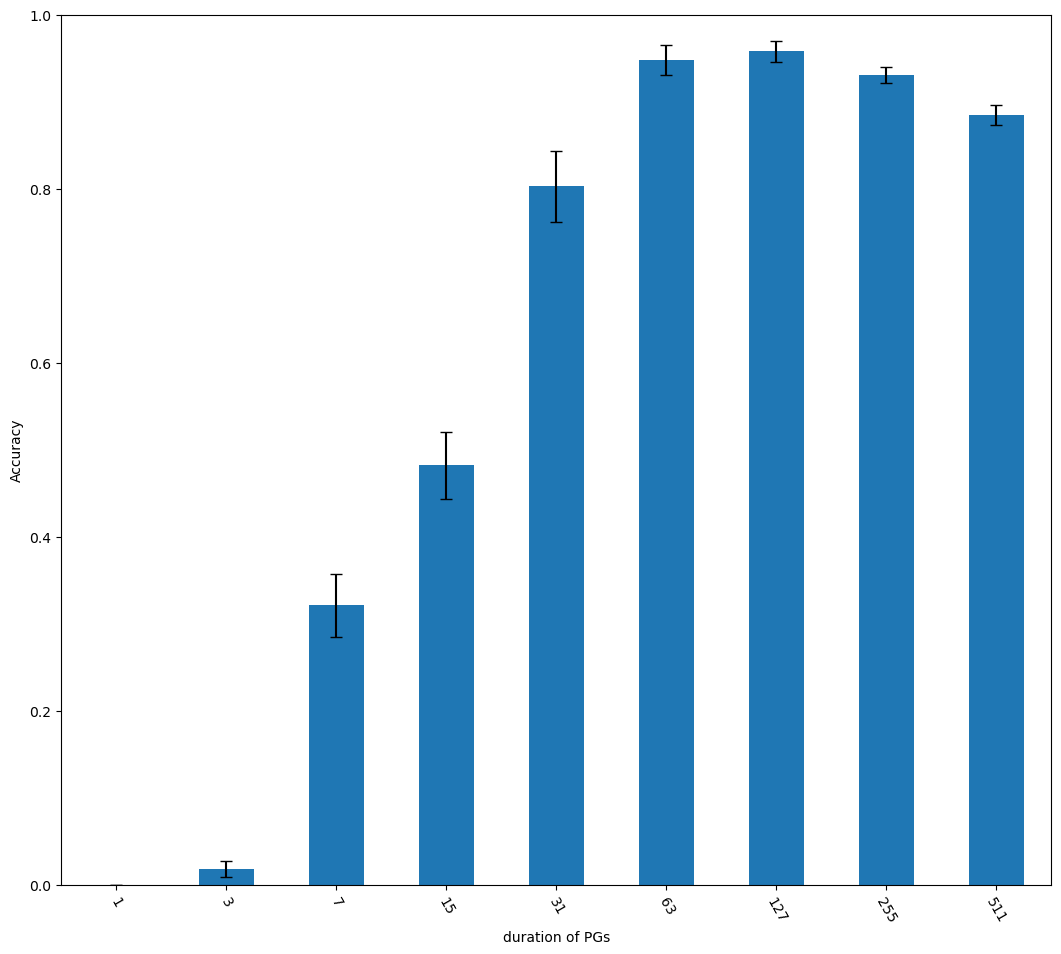

     N_pre  accuracy        TP        TN      time
0        8  0.998409  0.250660  0.999219  0.081683
1        8  0.998400  0.173410  0.999216  0.051387
2        8  0.998574  0.179567  0.999331  0.061507
3        8  0.998494  0.275204  0.999254  0.054868
4        8  0.998289  0.162011  0.999145  0.052060
..     ...       ...       ...       ...       ...
125   2351  0.999994  0.997159  0.999997  1.143083
126   2351  0.999966  0.983914  0.999983  1.058114
127   2351  0.999994  0.997333  0.999997  1.009195
128   2351  0.999983  0.991202  0.999991  1.026148
129   2351  0.999977  0.989975  0.999989  0.990378

[130 rows x 5 columns]


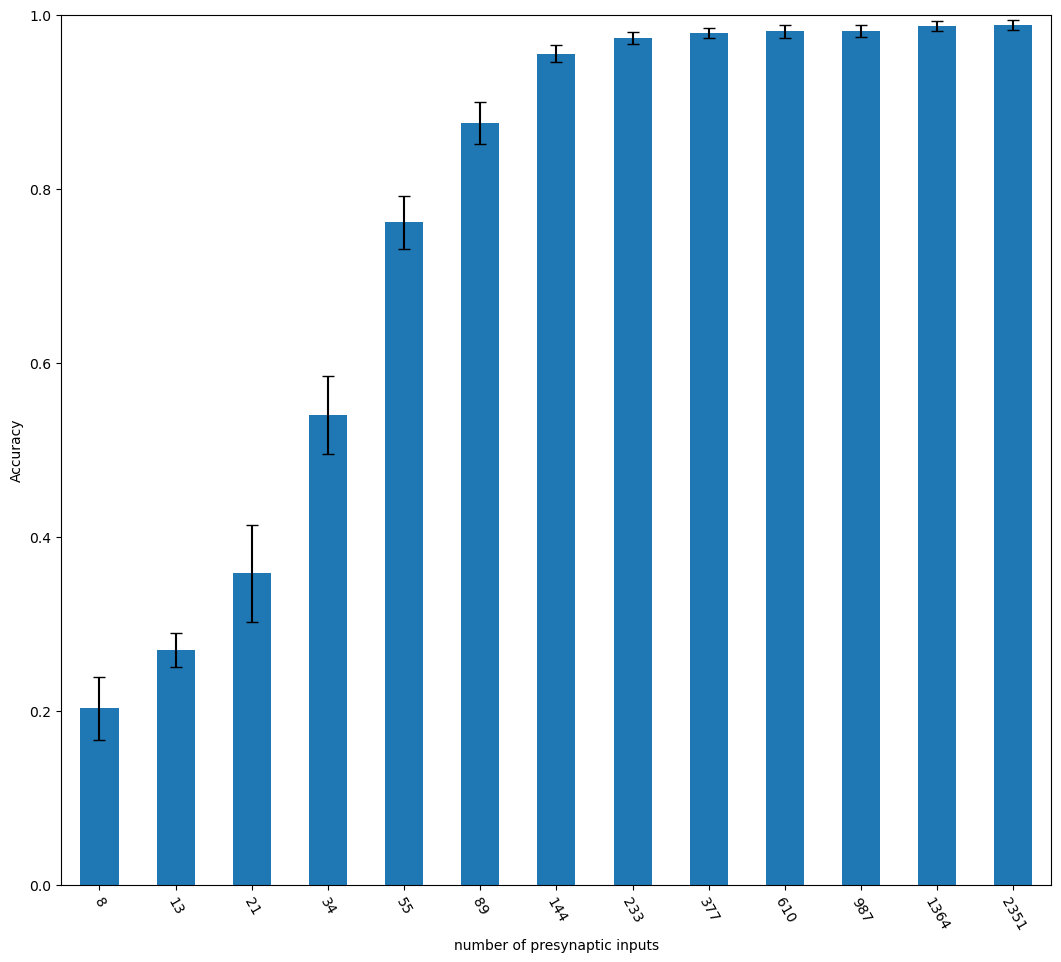

In [150]:

import matplotlib.pyplot as plt
for key in scan_dicts:
    filename = f'data_cache/{datetag}_scan_{key}.json'
    df_scan = pd.read_json(filename)
    print(df_scan)
    #for acc in ['TP', 'TN']
    #ax = df_scan.plot.scatter(x=key, y=['TP'], alpha=.1)
    #ax = df_scan.boxplot(column=key)
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html?highlight=errorbar#visualization-errorbars
    gp_scan = df_scan[[key, 'TP']].groupby([key])
    means = gp_scan.mean()
    errors = gp_scan.std()
    fig, ax = plt.subplots(figsize=(opt.fig_width, opt.fig_width), subplotpars=subplotpars)
    means.plot.bar(yerr=errors, ax=ax, capsize=4, rot=-60, legend=False)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(label_dicts[key])
    #ax.set_xscale('log')
    ax.set_ylim(0, 1)
    #fig = ax.get_figure()
    if not figpath is  None: printfig(fig, 'figure_' + key)
    plt.show()

# Online clustering

## testing inference with wrong PGs 

In [151]:
opt
opt.N_trials = 256
opt.N_PGs = 10

In [152]:
env = ABCD(opt)
env.opt

Params(datetag='2022-11-23', N_pre=144, N_PG_time=71, N_PGs=10, E_PG=4.0, p_PG=0.005, tau_decay=0.4, tau_rise=0.05, N_time=1000, N_trials=256, p_B=0.001, p_A=0.001, seed=42, verbose=False, fig_width=12, phi=1.61803, N_PG_show=5)

In [153]:
accuracy, TP, TN = env.test_model(PG=env.set_PG(seed=42), PG_true=env.set_PG(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.99%, TP=97.19%, TN=100.00%


In [154]:
accuracy, TP, TN = env.test_model(PG=env.set_PG(seed=51), PG_true=env.set_PG(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.81%, TP=6.42%, TN=99.91%


## learning 

In [168]:
PG_true = env.set_PG(seed=42)

class Net(torch.nn.Module):
    def __init__(self, N_pre, N_PGs, N_PG_time):
        super(Net, self).__init__()
        self.N_pre, self.N_PGs, self.N_PG_time = N_pre, N_PGs, N_PG_time
        # https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose1d.html#torch.nn.ConvTranspose1d
        self.convT = torch.nn.ConvTranspose1d(self.N_pre, self.N_PGs, self.N_PG_time, 
                                              padding=self.N_PG_time//2, bias=False)
        self.sigma = torch.nn.Sigmoid()

    def forward(self, a):
        # N_trials, N_pre, N_time = a.shape
        b_hat = self.convT(a*1.)
        # N_trials, N_PGs, N_time = b_hat.shape
        return self.sigma(b_hat)

def learn_model(env, PG, PG_true, N_learnsteps=2**12, 
                #N_time=1000, # N_time_blur=200, 
                lmbda=.001, p_B=opt.p_B, do_stochastic=False,
                lr=0.01, seed=None, seed_offset=5, do_supervised=False):
    if seed is None: seed = opt.seed + seed_offset
    torch.manual_seed(seed)
    
    N_pre, N_PGs, N_PG_time = PG.shape

    # https://pytorch.org/docs/master/generated/torch.nn.BCEWithLogitsLoss.html
    criterion = torch.nn.BCEWithLogitsLoss()
    # https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
    # criterion = torch.nn.BCELoss()
    criterion_reg = torch.nn.BCELoss()

    model = Net(N_pre, N_PGs, N_PG_time)
    model = model.to(device)

    PG_true = PG_true.to(device)

    #optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i_step in range(N_learnsteps):
        # draw causes (PGs) - hidden to the observer
        b_true = env.get_b(seed=seed+i_step).to(device)
        # generate the corresponding raster plot = what is observed
        a = env.draw_a(b_true, PG_true, seed=seed+i_step+1).to(device)
        # print('A', a.min().item(), a.max().item())

        # learn the PGs
        optimizer.zero_grad()
        if do_supervised: # supervised learning
            b_hat_bin = 1. * b_true
        else:
            b_hat = model(a)
            if do_stochastic:
                b_hat_bin = torch.bernoulli(model(a))
            else:
                b_threshold = torch.quantile(b_hat.ravel()[:10000000], 1-env.opt.p_B)
                b_hat_bin = (b_hat > b_threshold) * 1.
        
        
        # TODO: make a threshold per PG
        a_hat = env.model_a_logit(b_hat_bin, model.convT.weight)
        # print('A', a_hat.min().item(), a_hat.max().item(), a.min().item(), a.max().item())
        # print('B', b_hat.min().item(), b_hat.max().item(), b_hat_bin.min().item(), b_hat_bin.max().item())
        loss = criterion(a_hat, a*1.)

        loss += lmbda * criterion_reg(b_hat_bin.mean(axis=(0, 2)), p_B*torch.ones(N_PGs))
        
        loss.backward()
        optimizer.step()

        # b_hat = b_hat.cpu()
        # b_true = b_true.cpu()
        # b_hat_bin = b_hat_bin.to(device)
        if i_step % (N_learnsteps//64) == 0:
            print(f'Train Epoch [{i_step:06d}/{N_learnsteps:06d}]\tLoss: {loss.item():.6f}\tAccuracy: {torch.mean((b_hat_bin == b_true)*1.):.6f}\tTP: {torch.mean(b_hat_bin[b_true==1]*1.):.6f}')
    return model

In [156]:
subplotpars_learn = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)


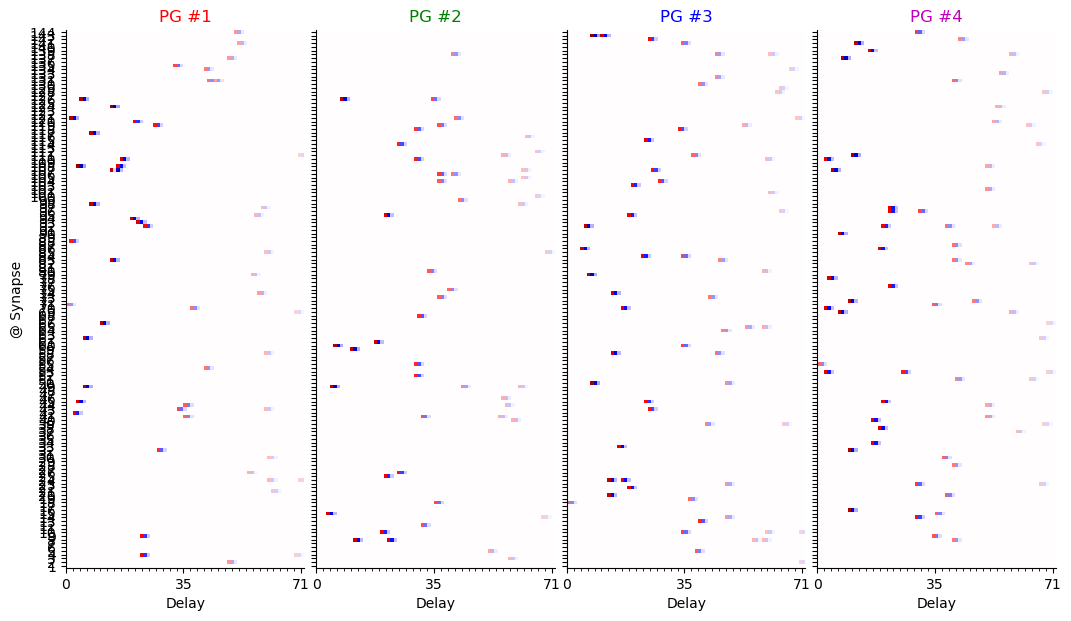

In [157]:
fig, axs = env.plot_PG(PG_true, colors=colors, N_PG_show=4, subplotpars=subplotpars_learn)

In [158]:
PG_start = env.set_PG(seed=51)
PG_start = env.opt.E_PG * torch.randn(env.opt.N_pre, env.opt.N_PGs, env.opt.N_PG_time)
N_pre, N_PGs, N_PG_time = PG_start.shape
model = Net(N_pre, N_PGs, N_PG_time)

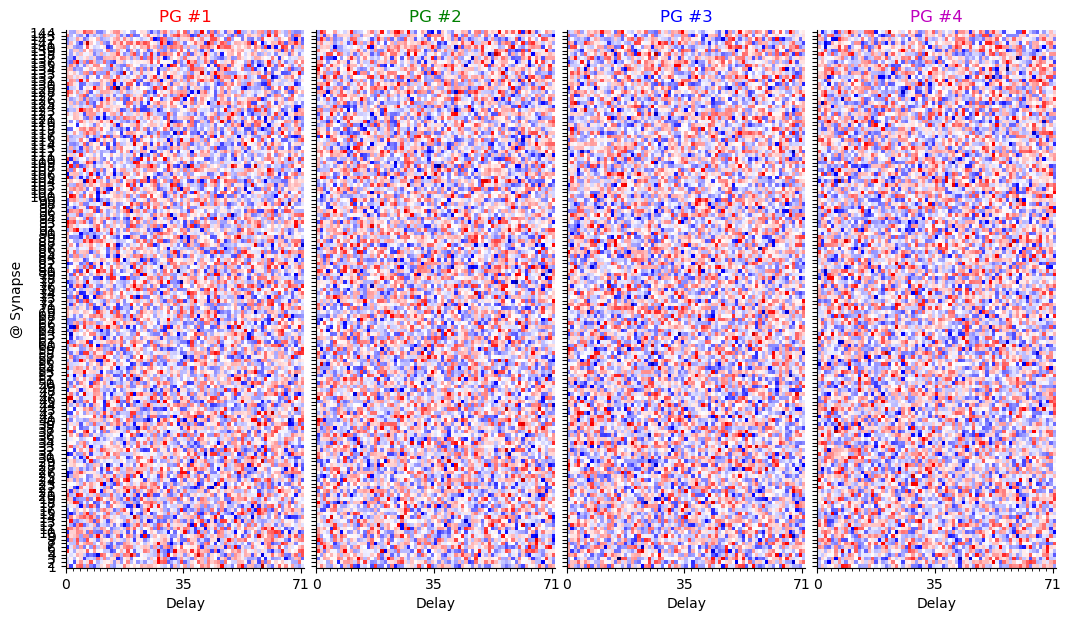

In [159]:
fig, axs = env.plot_PG(PG_start, colors=colors, N_PG_show=4, subplotpars=subplotpars_learn)

In [160]:
model = Net(N_pre, N_PGs, N_PG_time)

In [161]:
model.convT.weight.shape

torch.Size([144, 10, 71])

In [162]:
b_true = env.get_b(seed=seed).to(device)
# generate the corresponding raster plot = what is observed
a = env.draw_a(b_true, PG_true.to(device), seed=seed+1)
a.min(), a.max()

(tensor(0.), tensor(1.))

In [163]:
model = learn_model(env, PG_start, PG_true, do_supervised=True, N_learnsteps=2**10)

Train Epoch [000000/001024]	Loss: 0.012075	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000016/001024]	Loss: 0.011666	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000032/001024]	Loss: 0.011394	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000048/001024]	Loss: 0.011570	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000064/001024]	Loss: 0.011519	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000080/001024]	Loss: 0.011273	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000096/001024]	Loss: 0.011295	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000112/001024]	Loss: 0.011324	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000128/001024]	Loss: 0.011084	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000144/001024]	Loss: 0.011037	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000160/001024]	Loss: 0.010840	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000176/001024]	Loss: 0.010793	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000192/001024]	Loss: 0.010722	Accuracy: 1.000000	TP: 1.000000
Train Epoch [000208/00102

In [164]:
PG_hat = model.convT.weight.detach().cpu().numpy()
print(PG_hat.min(), PG_hat.mean(), PG_hat.max())

-2.771707 0.05017218 7.8446875


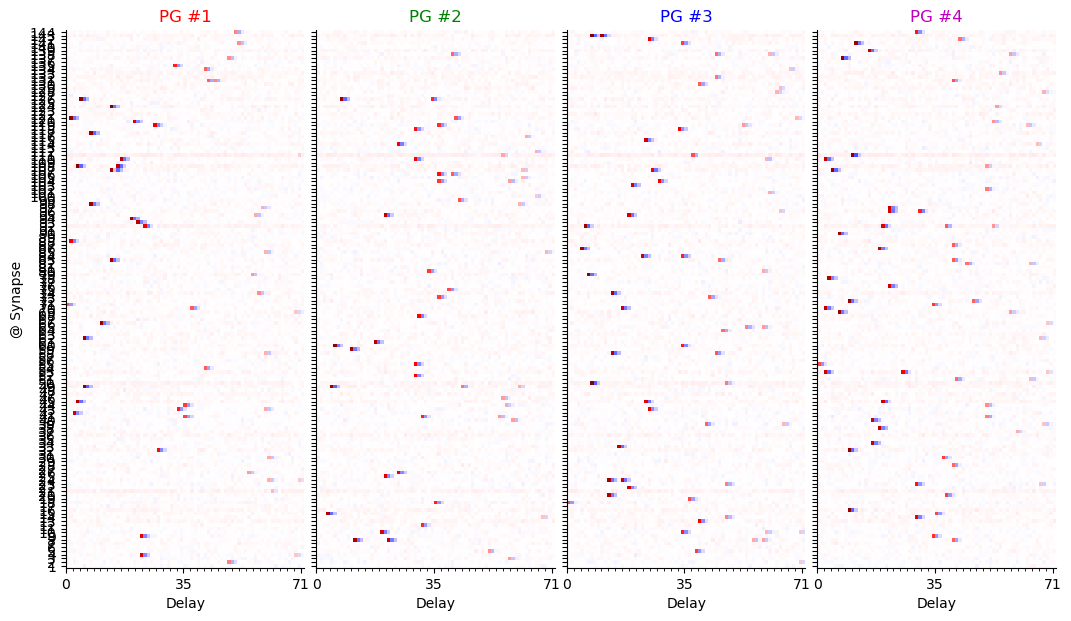

In [165]:
fig, axs = env.plot_PG(PG_hat, colors=colors, N_PG_show=4, subplotpars=subplotpars_learn)

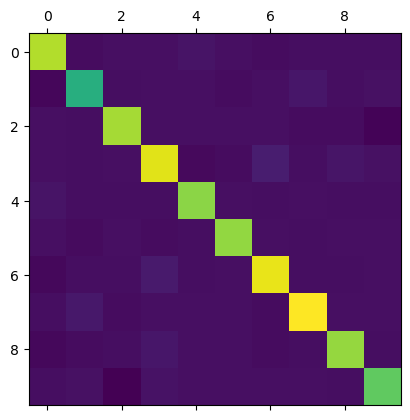

In [166]:
plt.matshow((PG_hat[:, None, :, :] * PG_true.numpy()[:, :, None, :]).mean(axis=(0, -1)));

In [169]:
model = learn_model(env, PG_start, PG_true, do_supervised=False)

Train Epoch [000000/004096]	Loss: 0.012049	Accuracy: 0.997971	TP: 0.001513
Train Epoch [000064/004096]	Loss: 0.011417	Accuracy: 0.998007	TP: 0.004669
Train Epoch [000128/004096]	Loss: 0.011115	Accuracy: 0.998030	TP: 0.006958
Train Epoch [000192/004096]	Loss: 0.011983	Accuracy: 0.998998	TP: 0.000000
Train Epoch [000256/004096]	Loss: 0.011952	Accuracy: 0.999015	TP: 0.000000
Train Epoch [000320/004096]	Loss: 0.011991	Accuracy: 0.998996	TP: 0.000000
Train Epoch [000384/004096]	Loss: 0.012062	Accuracy: 0.998982	TP: 0.000000
Train Epoch [000448/004096]	Loss: 0.011904	Accuracy: 0.999020	TP: 0.000000
Train Epoch [000512/004096]	Loss: 0.012124	Accuracy: 0.998960	TP: 0.000000
Train Epoch [000576/004096]	Loss: 0.012036	Accuracy: 0.999002	TP: 0.000000
Train Epoch [000640/004096]	Loss: 0.012182	Accuracy: 0.998977	TP: 0.000000
Train Epoch [000704/004096]	Loss: 0.011982	Accuracy: 0.999003	TP: 0.000000
Train Epoch [000768/004096]	Loss: 0.012057	Accuracy: 0.998993	TP: 0.000000
Train Epoch [000832/00409

In [ ]:
PG_hat = model.convT.weight.detach().cpu().numpy()
print(PG_hat.min(), PG_hat.mean(), PG_hat.max())

In [ ]:
fig, axs = env.plot_PG(PG_hat, colors=colors, N_PG_show=4, subplotpars=subplotpars_learn)

In [ ]:
fig, axs = env.plot_PG(PG_hat, N_PG_show=10, subplotpars=subplotpars_learn)

In [ ]:
PG_true = PG_true.numpy()

In [ ]:
PG_hat.shape, PG_true.shape

In [ ]:
plt.matshow((PG_hat[:, None, :, :] * PG_true.numpy()[:, :, None, :]).mean(axis=(0, -1)))

# Annex